In [ ]:
# If pulled changes from github are not reflected, uncomment this code block. Furthermore, restart all of your runtimes. 
# Colab sometimes seems to cache executed code from github, not using the latest pulled changes.
# %cd /content
# !rm -rf *

/content


## Download our dataset from our Dropbox and our main dependencies
Make sure to add all newly created data to the `combined_jsons` folder in our shared dropbox. The data will be directly curled from it.

In [ ]:
import os

REPO = "confusion_detection"
%cd /content

if not os.path.exists(f"/content/{REPO}"):
  !rm -rf *
  !git clone https://github.com/leomorpho/confusion_detection.git
  %cd confusion_detection
else:
  %cd /content
  %cd confusion_detection
  !git fetch --all
  !git reset --hard origin/master

assert(os.getcwd() == "/content/confusion_detection")

/content
Cloning into 'confusion_detection'...
remote: Enumerating objects: 893, done.
remote: Counting objects: 100% (893/893), done.
remote: Compressing objects: 100% (662/662), done.
remote: Total 7404 (delta 434), reused 674 (delta 219), pack-reused 6511
Receiving objects: 100% (7404/7404), 154.33 MiB | 21.72 MiB/s, done.
Resolving deltas: 100% (671/671), done.
/content/confusion_detection


## Preprocess

In [ ]:
from glob import glob
from typing import *
import json

DATA_DIR = "data/combined_jsons"
dataset_paths = glob(f"{DATA_DIR}/*")
print("dataset_paths is: ", dataset_paths)
print("dataset_paths count is: ", len(dataset_paths))

length_75 = []
length_55 = []
length_75_count = 0
length_55_count = 0
length_unknown = []
length_unknown_count = 0
indeces_to_pop = []
# Create single list object from all the JSONs
raw_sequences: List[List[List[float]]] = []
for path in dataset_paths:
  with open(path, "r") as f:
    sequences = json.loads(f.read())
    for seq in sequences:
      if len(seq) > 55:
        length_75_count += 1
        length_75.append([path, seq])
      elif len(seq) == 55:
        length_55_count += 1
        length_55.append([path, seq])
      else:
        length_unknown_count += 1
        length_unknown.append([path, seq])
    raw_sequences.append(sequences)

# Remove all frames that do not have 55 features (Confusion Score + 54 OpenPose points)
for i in range(len(raw_sequences)):
  for j in range(len(raw_sequences[i])):
    if len(raw_sequences[i][len(raw_sequences[i])-j-1]) != 55:
      # print("not 55: ", len(raw_sequences[i][len(raw_sequences[i])-j-1]))
      indeces_to_pop.append([i, len(raw_sequences[i])-j-1])


print("Number of indeces to pop: ", len(indeces_to_pop))
for (i, j) in sorted(indeces_to_pop, reverse=True):
  raw_sequences[i].pop(j)


print("length_75_count is: ", length_75_count)
print("length_55_count is: ", length_55_count)
print("length_unknown_count is: ", length_unknown_count)
print("length of raw_sequences is: ", len(raw_sequences))

# print("length_75 is: ", len(length_75))
# print("length_55 is: ", len(length_55))
# print("length_unknown is: ", len(length_unknown))

# for (path, seq) in length_75:
#   print("length_75 is: ", path)

# for (path, seq) in length_unknown:
#   print("length_unknown is: ", path)
# #   print("length is: ", len(seq))


dataset_paths is:  ['data/combined_jsons/2019-10-15-14-15-19bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-16-14-12-40bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-15-14-22-48bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-15-14-15-19bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-24-14-32-29bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-15-14-12-10bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-15-05-09bag_img_raw_03_combined.json', 'data/combined_jsons/2019-10-10-14-24-28bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-14-25-07bag_img_raw_04_combined.json', 'data/combined_jsons/2019-10-24-15-05-09bag_img_raw_01_combined.json', 'data/combined_jsons/2019-10-24-15-21-13bag_img_raw_03_combined.json', 'data/combined_jsons/2019-11-05-14-14-31bag_img_raw_03_combined.json', 'data/combined_jsons/2019-12-05-14-20-24bag_img_raw_04_combined.json', 'data/combined_jsons/2019-12-05-15-15-46bag_img_raw_01_co

In [ ]:
number_of_zeroes = 0
number_of_ones = 0
number_of_twos = 0
number_of_threes = 0
total_count = 0

for sequence in raw_sequences:
  for frame in sequence:
    total_count += 1
    if int(frame[0]) == 0:
      number_of_zeroes += 1
    elif int(frame[0]) == 1:
      number_of_ones += 1
    elif int(frame[0]) == 2:
      number_of_twos += 1
    elif int(frame[0]) == 3:
      number_of_threes += 1

print(f"0: {number_of_zeroes}")
print(f"1: {number_of_ones}")
print(f"2: {number_of_twos}")
print(f"3: {number_of_threes}")
print(f"total_count: {total_count}")
print(f"total_count - number_of_zeroes: {total_count - number_of_zeroes}")

0: 3955
1: 16081
2: 11363
3: 11445
total_count: 42844
total_count - number_of_zeroes: 38889


Get centroid for every frame. If the centroid differs widely between 2 frames, it may indicate that different people were picked up by OpenPose.
Centroid code taken from [here](https://stackoverflow.com/questions/23020659/fastest-way-to-calculate-the-centroid-of-a-set-of-coordinate-tuples-in-python-wi).

Format of OpenPose output can be found [here](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md). A frame is represented by `x1,y1,c1,x2,y2,c2,...`

If a dropped frame is between 2 valid sequences, consider stitching them back together.
* Drop frames which have **no subject** in them. DONE.
* Drop frames which have **wrong** subject in them.  DONE.
* Give unit variance and zero mean to all points. DONE.

In [ ]:
from jupyter_tools.preprocessing import stitch_frames, normalize

print(f"Number of raw sequences:        {len(raw_sequences)}")
parsed_sequences = stitch_frames(raw_sequences, min_dist=50, min_sequence_len=40, max_dropped_frames=4)
print(f"Number of stitched sequences:   {len(parsed_sequences)}")
normalized_sequences = normalize(parsed_sequences)
print(f"Number of normalized sequences: {len(normalized_sequences)}")

# CAUTION: further code should ONLY refer to "preprocessed_sequences".
# This prevent breakages if code changes.
preprocessed_sequences = normalized_sequences

Number of raw sequences:        146
Number of stitched sequences:   201
Number of normalized sequences: 201


In [ ]:
# Get some info on preprocessed_sequences
number_of_zeroes = 0
number_of_ones = 0
number_of_twos = 0
number_of_threes = 0
total_count = 0

for sequence in preprocessed_sequences:
  for frame in sequence:
    total_count += 1
    if int(frame[0]) == 0:
      number_of_zeroes += 1
    elif int(frame[0]) == 1:
      number_of_ones += 1
    elif int(frame[0]) == 2:
      number_of_twos += 1
    elif int(frame[0]) == 3:
      number_of_threes += 1

print(f"0: {number_of_zeroes}")
print(f"1: {number_of_ones}")
print(f"2: {number_of_twos}")
print(f"3: {number_of_threes}")
print(f"total_count: {total_count}")
print(f"total_count - 0's: {total_count - number_of_zeroes}")

0: 0
1: 9461
2: 6817
3: 8135
total_count: 24413
total_count - 0's: 24413


In [ ]:
import pandas as pd

# Get some stats about the length of the processed sequences
sequences_len = []
for sequence in preprocessed_sequences:
  sequences_len.append(len(sequence))

a = pd.DataFrame(sequences_len)
a.describe()

,0
count,201.000000
mean,121.457711
std,102.400388
min,40.000000
25%,54.000000
50%,84.000000
75%,143.000000
max,683.000000


## Model
Create 3 models
* Simple RNN
* LSTM/GRU RNN

For testing, it would be beneficial to write a function (in `jupyter_tools`) to display the frames as a video with a label indicating the prediction from the model.

First, we need to extract the X and Y values from our dataset in order to use them on the model.
Our Y will be our confusion annotations, and our X will be all the openPose coordinates.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

nn_input_data = np.asarray(preprocessed_sequences)

nn_data = []
nn_target = []
# Split the data into data and target arrays
for row in range(len(nn_input_data)):
    for frame in range(len(nn_input_data[row])):
        target = nn_input_data[row][frame][0]
        data = []
        for datum in nn_input_data[row][frame][1:]:
          data.append(datum)
        # data = nn_input_data[row][frame][1:]
        nn_data.append(data)
        nn_target.append(target)
print("done")

done


In [ ]:
## Because we have stripped away all 0s from the Confusion Score,
## The target set must now be reduced from 1-3 to 0-2, to play nicely with the models
nn_target_reduced = []
target_counts = [0,0,0]
print("Previous Values: ", nn_target[0:10])
for i in range(len(nn_target)):
  if nn_target[i] == 3:
    nn_target_reduced.append(2)
    target_counts[2] += 1
  elif nn_target[i] == 2:
    nn_target_reduced.append(1)
    target_counts[1] += 1
  elif nn_target[i] == 1:
    nn_target_reduced.append(0)
    target_counts[0] += 1
  else:
    print("found invalid value: ", nn_target[i])

print(" Current Values: ", nn_target_reduced[0:10])

print("Target Counts for the three possible scores: ", target_counts)

Previous Values:  [3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
 Current Values:  [2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
Target Counts for the three possible scores:  [9461, 6817, 8135]


In [ ]:
nn_data_np = np.asarray(nn_data)
nn_target_np = np.asarray(nn_target_reduced)
nn_data_pd = pd.DataFrame(nn_data)
nn_target_pd = pd.DataFrame(nn_target_reduced)

print("nn_data_pd shape is: ", nn_data_pd.shape)
print("nn_data_pd type is: ",nn_data_np.dtype)

# print(nn_data_np[0])

nn_data_pd shape is:  (24413, 54)
nn_data_pd type is:  float64


### Statistics for the data
There are currently 54 features

In [ ]:
nn_data_pd.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
count,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000,24415.000000
mean,0.417810,-0.297098,-1.053882,1.083312,0.035305,-1.052645,1.072547,0.034789,-1.052828,1.051108,0.235926,-1.053529,0.908754,0.183512,-1.054031,1.095088,0.033173,-1.052785,1.083471,0.239643,-1.053319,0.873902,0.175468,-1.053911,1.079888,0.477722,-1.053247,1.074900,0.783282,-1.053099,1.021501,0.990719,-1.053463,1.094537,0.478410,-1.053206,1.083262,0.784136,-1.053053,1.027558,0.996417,-1.053459,0.333872,-0.486292,-1.054749,0.245441,-0.456380,-1.054475,0.534926,-0.408728,-1.054447,0.415466,-0.333225,-1.053996
std,1.021174,0.445004,0.129771,0.428691,0.346673,0.130260,0.452470,0.344325,0.130154,0.497969,0.429568,0.130185,0.738630,0.550247,0.130031,0.433550,0.348575,0.130217,0.482848,0.444054,0.130197,0.743741,0.565757,0.129958,0.423083,0.508625,0.130114,0.432389,0.631942,0.130212,0.542029,0.811536,0.130344,0.405264,0.512299,0.130103,0.415071,0.638302,0.130198,0.529487,0.827409,0.130316,1.090319,0.462402,0.129812,1.042618,0.486433,0.129744,1.062941,0.491395,0.130387,1.000083,0.517195,0.130296
min,-1.257885,-1.109977,-1.398062,-0.573959,-0.610912,-1.395453,-0.803860,-0.712949,-1.395578,-1.113973,-1.113973,-1.396565,-1.269707,-1.269707,-1.396903,-0.916112,-0.916112,-1.395838,-1.193997,-1.193997,-1.397485,-1.290381,-1.290381,-1.398563,-0.689930,-0.654779,-1.395489,-1.198909,-1.198909,-1.396956,-1.258818,-1.258818,-1.397627,-0.903579,-0.903579,-1.395237,-1.147322,-1.147322,-1.396947,-1.273625,-1.273625,-1.397610,-1.291374,-1.291374,-1.398303,-1.274216,-1.274216,-1.398172,-1.291909,-1.291909,-1.398606,-1.292659,-1.292659,-1.397956
25%,-0.823394,-0.470595,-1.139926,0.981057,-0.236069,-1.139515,0.959280,-0.232284,-1.139623,0.932784,-0.071616,-1.140495,0.783952,-0.092853,-1.140497,0.986516,-0.240926,-1.139572,0.959423,-0.084523,-1.140150,0.697222,-0.116303,-1.140109,0.987287,0.091270,-1.140030,0.987633,0.304303,-1.139786,0.959018,0.472089,-1.140283,0.991471,0.088502,-1.140007,0.984298,0.300710,-1.139772,0.938203,0.465397,-1.139955,-0.961050,-0.961050,-1.140914,-0.956062,-0.956062,-1.140621,-0.923934,-0.923934,-1.140995,-0.932659,-0.932659,-1.141003
50%,1.017845,-0.283905,-1.057961,1.230296,-0.058506,-1.056321,1.205736,-0.054772,-1.056476,1.186073,0.142024,-1.057093,1.164838,0.139140,-1.057916,1.243821,-0.060233,-1.056465,1.248858,0.135950,-1.056854,1.175432,0.113391,-1.057351,1.211958,0.360119,-1.056882,1.213197,0.656029,-1.056695,1.204361,0.885500,-1.057075,1.238212,0.358716,-1.056880,1.234496,0.653521,-1.056718,1.221080,0.889094,-1.057153,0.977459,-0.414595,-1.059086,0.717577,-0.412839,-1.058562,1.123505,-0.348323,-1.058165,0.931171,-0.271800,-1.057723
75%,1.281367,-0.029571,-0.981386,1.352867,0.261504,-0.980178,1.352563,0.257137,-0.980291,1.356209,0.468289,-0.980993,1.384922,0.480519,-0.981323,1.377656,0.262628,-0.980311,1.392996,0.509522,-0.981145,1.369843,0.492563,-0.981824,1.341273,0.747408,-0.980769,1.339154,1.067593,-0.980349,1.332689,1.346050,-0.980762,1.356763,0.749818,-0.980705,1.351180,1.073512,-0.980315,1.339497,1.348318,-0.980687,1.306751,-0.200158,-0.981998,1.232730,-0.139635,-0.982257,1.354893,-0.109661,-0.981440,1.261194,0.032479,-0.981911
max,1.838729,1.070167,-0.243291,2.9627

In [ ]:
nn_target_pd.describe()

,0
count,24415.000000
mean,0.945607
std,0.847265
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,2.000000


Next, apply the data to the Models

1.   Simple Sequential NN
2.   LSTM



In [ ]:
# Split the data into training and test sets
twenty_percent_split = int(np.floor(len(nn_data_np) * 0.8))
x_train_split = nn_data_np[0:twenty_percent_split]
x_test_split = nn_data_np[twenty_percent_split:]
y_train_split = nn_target_np[0:twenty_percent_split]
y_test_split = nn_target_np[twenty_percent_split:]

# Split the training set into train & validation
twenty_percent_validate_split = int(np.floor(len(x_train_split) * 0.8))
x_train = x_train_split[0:twenty_percent_validate_split]
x_validate = x_train_split[twenty_percent_validate_split:]
y_train = y_train_split[0:twenty_percent_validate_split]
y_validate =  y_train_split[twenty_percent_validate_split:]

print("x_train length is: ", len(x_train))
print("x_validate length is: ", len(x_validate))
print("x_test_split length is: ", len(x_test_split))

x_train length is:  15624
x_validate length is:  3906
x_test_split length is:  4883


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Build the model, compile it, and run the training
snn_model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

snn_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

snn_history = snn_model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2, validation_data=(x_validate, y_validate))

Epoch 1/10
15624/15624 - 15s - loss: 1.0893 - accuracy: 0.3698 - val_loss: 1.0735 - val_accuracy: 0.4337
Epoch 2/10
15624/15624 - 15s - loss: 1.0834 - accuracy: 0.3721 - val_loss: 1.1047 - val_accuracy: 0.3241
Epoch 3/10
15624/15624 - 15s - loss: 1.0782 - accuracy: 0.3916 - val_loss: 1.1215 - val_accuracy: 0.3277
Epoch 4/10
15624/15624 - 15s - loss: 1.0747 - accuracy: 0.3999 - val_loss: 1.0985 - val_accuracy: 0.4283
Epoch 5/10
15624/15624 - 15s - loss: 1.0681 - accuracy: 0.4105 - val_loss: 1.1103 - val_accuracy: 0.3065
Epoch 6/10
15624/15624 - 15s - loss: 1.0660 - accuracy: 0.4126 - val_loss: 1.1083 - val_accuracy: 0.3733
Epoch 7/10
15624/15624 - 15s - loss: 1.0620 - accuracy: 0.4148 - val_loss: 1.1120 - val_accuracy: 0.4186
Epoch 8/10
15624/15624 - 15s - loss: 1.0596 - accuracy: 0.4215 - val_loss: 1.1072 - val_accuracy: 0.4283
Epoch 9/10
15624/15624 - 15s - loss: 1.0563 - accuracy: 0.4259 - val_loss: 1.1346 - val_accuracy: 0.3948
Epoch 10/10
15624/15624 - 15s - loss: 1.0549 - accuracy

In [ ]:
# Get the target predictions for the test set on the trained model
predict_snn = snn_model.predict(x_test_split)

In [ ]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_snn)):
  rounded = []
  for j in range(len(predict_snn[i])):
    rounded.append(round(predict_snn[i][j], 3))
  
  # check if the prediction was correct or not
  if predict_snn[i][y_test_split[i]] == max(predict_snn[i]):
    correctness[0][0] += 1
    correctness[0][1] += predict_snn[i][y_test_split[i]]
    target_correctness[y_test_split[i]][0] += 1
  else:
    correctness[1][0] += 1
    correctness[1][1] += predict_snn[i][y_test_split[i]]
    correctness[1][2] += max(predict_snn[i])
    target_correctness[y_test_split[i]][1] += 1
  rounded_predict.append(rounded)

# compare actual score vs prediction for a subset of the array
# for i in range(1,80):
#   print(y_test_split[i], rounded_predict[i][y_test_split[i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Predictions per target value: ", target_correctness)
# print((correctness[0][0]+correctness[1][0]), len(predict_snn))

Results:  [[1644, 0.4578300443661474], [3239, 0.2764314154017414, 0.4553114518537018]]
Percentage Correct:  0.3366782715543723
Predictions per target value:  [[674, 1337, 0.3351566384883143], [80, 1366, 0.05532503457814661], [890, 536, 0.6241234221598878]]


In [ ]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for k in range(len(rounded_predict[i])):
    if predict_snn[i][k] > prediction_max[k]:
      prediction_max[k] = predict_snn[i][k]
    if predict_snn[i][k] < prediction_min[k]:
      prediction_min[k] = predict_snn[i][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.9783473, 0.9998167, 0.45189232]
min probability predictions:  [0.00018330505, 0.012382622, 4.1122195e-08]


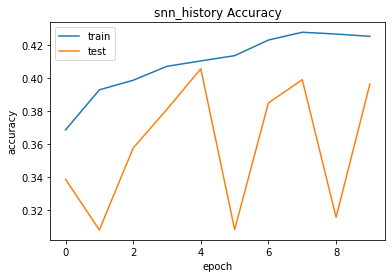

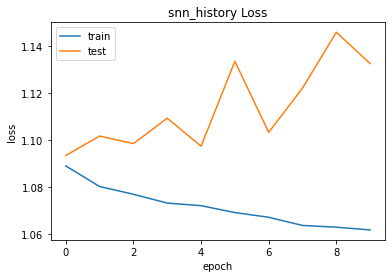

       loss  accuracy  val_loss  val_accuracy
0  1.088962  0.368664  1.093412      0.338710
1  1.080204  0.392985  1.101664      0.307988
2  1.076896  0.398810  1.098470      0.357655
3  1.073148  0.407258  1.109270      0.381208
4  1.072033  0.410522  1.097355      0.405786
5  1.069111  0.413722  1.133505      0.308244
6  1.067100  0.423195  1.103256      0.385049
7  1.063622  0.427931  1.122090      0.399130
8  1.062881  0.426843  1.145864      0.315668
9  1.061724  0.425435  1.132510      0.396569


In [ ]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize snn_history for accuracy
plt.plot(snn_history.history['accuracy'])
plt.plot(snn_history.history['val_accuracy'])
plt.title('snn_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize snn_history for loss
plt.plot(snn_history.history['loss'])
plt.plot(snn_history.history['val_loss'])
plt.title('snn_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(snn_history.history)
print(history_pd)

**Create a 3D array with a constant step-size for the LSTM**

In [ ]:
import numpy as np

number_of_features = 54
window_size = 10
window_size_array_x = []
window_size_array_y = []
index = 0
while index <= len(nn_data):
  if index+window_size > len(nn_data):
    break
  data_x = []
  data_y = []
  for i in range(index, index+window_size, 1):
    data_x.append(tf.convert_to_tensor(nn_data[i][:number_of_features]))
    data_y.append(tf.convert_to_tensor(nn_target_reduced[i]))
  window_size_array_x.append(data_x)
  window_size_array_y.append(data_y)
  index += window_size

print("done")

done


### Train Model

In [ ]:
## THIS CELL TAKES QUITE A WHILE TO PROCESS (just a heads up)

# Split the data into training and test sets
twenty_percent_split = int(np.floor(len(window_size_array_x) * 0.8))
x_train_split = window_size_array_x[0:twenty_percent_split]
x_test_split = window_size_array_x[twenty_percent_split:]
y_train_split = window_size_array_y[0:twenty_percent_split]
y_test_split = window_size_array_y[twenty_percent_split:]

# Split Train set into train & validation
twenty_percent_validate_split = int(np.floor(len(x_train_split) * 0.8))
x_train_temp = x_train_split[0:twenty_percent_validate_split]
x_validate = x_train_split[twenty_percent_validate_split:]
y_train_temp = y_train_split[0:twenty_percent_validate_split]
y_validate =  y_train_split[twenty_percent_validate_split:]
print("arrays have been split")

# Convert the arrays into npArrays
x_train_lstm = np.asarray(x_train_temp)
print("x_train_temp has been converted to np")
x_validate_lstm = np.asarray(x_validate)
print("x_validate has been converted to np")
x_test_lstm = np.asarray(x_test_split)
print("x_test1 has been converted to np")
y_train_lstm = np.asarray(y_train_temp)
print("y_train_temp has been converted to np")
y_validate_lstm = np.asarray(y_validate)
print("y_validate has been converted to np")
y_test_lstm = np.asarray(y_test_split)
print("y_test1 has been converted to np")

print("x_train_lstm shape is: ", x_train_lstm.shape)
print("x_validate_lstm shape is: ", x_validate_lstm.shape)

arrays have been split
x_train_temp has been converted to np
x_validate has been converted to np
x_test1 has been converted to np
y_train_temp has been converted to np
y_validate has been converted to np
y_test1 has been converted to np
x_train_lstm shape is:  (1561, 10, 54)
x_validate_lstm shape is:  (391, 10, 54)


In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# We could potentially use EarlyStopping to limit required amount of epochs with: ,callbacks = [early_stopping]
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=4, mode='auto')

# As a general rule-of-thumb, the number of hidden layers should roughly equal Ns / (alpha*(Ni+No))
hidden_nodes = int(len(x_train_lstm) / (6 * (54+3)))
print("number of hidden nodes: ", hidden_nodes)

simple_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dense(3, activation='softmax')
])

simple_lstm_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

simple_lstm_history = simple_lstm_model.fit(x_train_lstm, y_train_lstm, 
               batch_size=window_size, epochs=10, verbose=2,
               callbacks=[early_stopping],
               validation_data=(x_validate_lstm, y_validate_lstm))

print("done")

number of hidden nodes:  4
Epoch 1/10
157/157 - 1s - loss: 1.1026 - accuracy: 0.3494 - val_loss: 1.0861 - val_accuracy: 0.3693
Epoch 2/10
157/157 - 1s - loss: 1.0876 - accuracy: 0.3883 - val_loss: 1.0862 - val_accuracy: 0.4023
Epoch 3/10
157/157 - 1s - loss: 1.0846 - accuracy: 0.3950 - val_loss: 1.0829 - val_accuracy: 0.4171
Epoch 4/10
157/157 - 1s - loss: 1.0821 - accuracy: 0.4031 - val_loss: 1.0867 - val_accuracy: 0.3770
Epoch 5/10
157/157 - 1s - loss: 1.0810 - accuracy: 0.4059 - val_loss: 1.0888 - val_accuracy: 0.3749
Epoch 6/10
157/157 - 1s - loss: 1.0796 - accuracy: 0.3995 - val_loss: 1.0811 - val_accuracy: 0.4315
Epoch 7/10
157/157 - 1s - loss: 1.0775 - accuracy: 0.4060 - val_loss: 1.0811 - val_accuracy: 0.4161
Epoch 8/10
157/157 - 1s - loss: 1.0763 - accuracy: 0.4099 - val_loss: 1.0892 - val_accuracy: 0.3696
Epoch 9/10
157/157 - 1s - loss: 1.0744 - accuracy: 0.4076 - val_loss: 1.0849 - val_accuracy: 0.3977
Epoch 10/10
157/157 - 1s - loss: 1.0741 - accuracy: 0.4106 - val_loss: 1.

In [ ]:
complex_lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(hidden_nodes, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

complex_lstm_model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

complex_lstm_history = complex_lstm_model.fit(x_train_lstm, y_train_lstm, 
               batch_size=window_size, epochs=10, verbose=2,
               callbacks=[early_stopping],
               validation_data=(x_validate_lstm, y_validate_lstm))

print("done")

Epoch 1/10
157/157 - 3s - loss: 1.0950 - accuracy: 0.3619 - val_loss: 1.0856 - val_accuracy: 0.4054
Epoch 2/10
157/157 - 1s - loss: 1.0906 - accuracy: 0.3690 - val_loss: 1.0867 - val_accuracy: 0.4102
Epoch 3/10
157/157 - 1s - loss: 1.0888 - accuracy: 0.3801 - val_loss: 1.0828 - val_accuracy: 0.3936
Epoch 4/10
157/157 - 1s - loss: 1.0885 - accuracy: 0.3851 - val_loss: 1.0840 - val_accuracy: 0.3949
Epoch 5/10
157/157 - 1s - loss: 1.0851 - accuracy: 0.3956 - val_loss: 1.0791 - val_accuracy: 0.4217
Epoch 6/10
157/157 - 2s - loss: 1.0867 - accuracy: 0.3931 - val_loss: 1.0872 - val_accuracy: 0.3675
Epoch 7/10
157/157 - 2s - loss: 1.0836 - accuracy: 0.3994 - val_loss: 1.0778 - val_accuracy: 0.4286
Epoch 8/10
157/157 - 1s - loss: 1.0827 - accuracy: 0.4003 - val_loss: 1.0813 - val_accuracy: 0.4292
Epoch 9/10
157/157 - 2s - loss: 1.0826 - accuracy: 0.3979 - val_loss: 1.0792 - val_accuracy: 0.4251
Epoch 10/10
157/157 - 2s - loss: 1.0826 - accuracy: 0.4009 - val_loss: 1.0814 - val_accuracy: 0.4176

In [ ]:
# Get the target predictions for the test set on the trained model
predict_simple_lstm = simple_lstm_model.predict(x_test_lstm)
predict_complex_lstm = complex_lstm_model.predict(x_test_lstm)

In [ ]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_simple_lstm)):
  rounded = []
  for j in range(len(predict_simple_lstm[i])):
    rounded_array = []
    for k in range(len(predict_simple_lstm[i][j])):
      rounded_array.append(round(predict_simple_lstm[i][j][k], 3))
    
    # check if the prediction was correct or not
    if predict_simple_lstm[i][j][y_test_lstm[i][j]] == max(predict_simple_lstm[i][j]):
      correctness[0][0] += 1
      correctness[0][1] += predict_simple_lstm[i][j][y_test_lstm[i][j]]
      target_correctness[y_test_lstm[i][j]][0] += 1
    else:
      correctness[1][0] += 1
      correctness[1][1] += predict_simple_lstm[i][j][y_test_lstm[i][j]]
      correctness[1][2] += max(predict_simple_lstm[i][j])
      target_correctness[y_test_lstm[i][j]][1] += 1
    rounded.append(rounded_array)
  rounded_predict.append(rounded)

# Compare actual score vs prediction for a subset of the array
# for j in range(1,20):
#   for i in range(window_size):
#     print(y_test_lstm[j][i], rounded_predict[j][i][y_test_lstm[j][i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("sLSTM Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Predictions per target value: ", target_correctness)
# print((correctness[0][0]+correctness[1][0]), len(predict_simple_lstm)*window_size)

sLSTM Results:  [[1721, 0.4064293418389154], [3169, 0.2991232518829657, 0.4004506073414847]]
Percentage Correct:  35.194274028629856
Predictions per target value:  [[1106, 911, 0.5483391175012394], [120, 1327, 0.082930200414651], [495, 931, 0.34712482468443195]]


In [ ]:
# Round and print prediction array to see the results of our model's prediction ability
rounded_predict = []
correctness = [[0, 0], [0, 0, 0]]
target_correctness = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
for i in range(len(predict_complex_lstm)):
  rounded = []
  for j in range(len(predict_complex_lstm[i])):
    rounded_array = []
    for k in range(len(predict_complex_lstm[i][j])):
      rounded_array.append(round(predict_complex_lstm[i][j][k], 3))
      # check if the prediction was correct or not
    if predict_complex_lstm[i][j][y_test_lstm[i][j]] == max(predict_complex_lstm[i][j]):
      correctness[0][0] += 1
      correctness[0][1] += predict_complex_lstm[i][j][y_test_lstm[i][j]]
      target_correctness[y_test_lstm[i][j]][0] += 1
    else:
      correctness[1][0] += 1
      correctness[1][1] += predict_complex_lstm[i][j][y_test_lstm[i][j]]
      correctness[1][2] += max(predict_complex_lstm[i][j])
      target_correctness[y_test_lstm[i][j]][1] += 1
    rounded.append(rounded_array)
  rounded_predict.append(rounded)

# Compare actual score vs prediction for a subset of the array
# for j in range(1,20):
#   for i in range(window_size):
#     print(y_test_lstm[j][i], rounded_predict[j][i][y_test_lstm[j][i]])

# Calculate the means for the predictions of correct and incorrect predictions
correctness[0][1] = correctness[0][1] / correctness[0][0]
correctness[1][1] = correctness[1][1] / correctness[1][0]
correctness[1][2] = correctness[1][2] / correctness[1][0]
percent_correct = correctness[0][0] / (correctness[0][0]+correctness[1][0])
target_correctness[0][2] = target_correctness[0][0] / (target_correctness[0][0]+target_correctness[0][1])
target_correctness[1][2] = target_correctness[1][0] / (target_correctness[1][0]+target_correctness[1][1])
target_correctness[2][2] = target_correctness[2][0] / (target_correctness[2][0]+target_correctness[2][1])

print("cLSTM Results: ", correctness)
print("Percentage Correct: ", percent_correct*100)
print("Predictions per target value: ", target_correctness)
# print((correctness[0][0]+correctness[1][0]), len(predict_simple_lstm)*window_size)

cLSTM Results:  [[1813, 0.3980958371516163], [3077, 0.3027777926300809, 0.39348591627298257]]
Percentage Correct:  37.07566462167689
Predictions per target value:  [[1531, 486, 0.7590480912245909], [13, 1434, 0.008984105044920525], [269, 1157, 0.18863955119214587]]


In [ ]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for j in range(len(rounded_predict[i])):
    for k in range(len(rounded_predict[i][j])):
      if predict_simple_lstm[i][j][k] > prediction_max[k]:
        prediction_max[k] = predict_simple_lstm[i][j][k]
      if predict_simple_lstm[i][j][k] < prediction_min[k]:
        prediction_min[k] = predict_simple_lstm[i][j][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.61199534, 0.4020795, 0.35933423]
min probability predictions:  [0.25672084, 0.10662991, 0.28133103]


In [ ]:
# Print the max & min values for prediction of each confusion score
prediction_max = [0,0,0]
prediction_min = [1,1,1]
for i in range(len(rounded_predict)):
  for j in range(len(rounded_predict[i])):
    for k in range(len(rounded_predict[i][j])):
      if predict_complex_lstm[i][j][k] > prediction_max[k]:
        prediction_max[k] = predict_complex_lstm[i][j][k]
      if predict_complex_lstm[i][j][k] < prediction_min[k]:
        prediction_min[k] = predict_complex_lstm[i][j][k]

print("max probability predictions: ", prediction_max)
print("min probability predictions: ", prediction_min)

max probability predictions:  [0.5317115, 0.35338846, 0.35167396]
min probability predictions:  [0.3007093, 0.14419152, 0.324097]


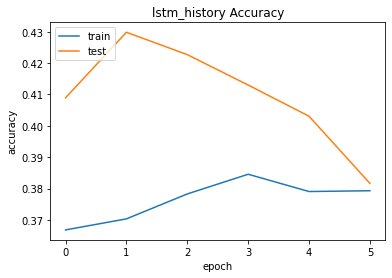

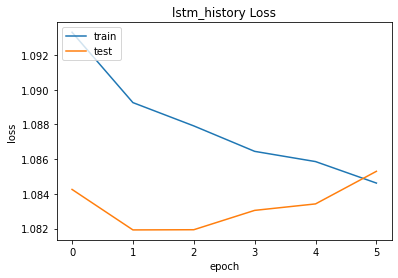

       loss  accuracy  val_loss  val_accuracy
0  1.093310  0.366795  1.084253      0.408929
1  1.089255  0.370320  1.081921      0.429847
2  1.087913  0.378269  1.081932      0.422704
3  1.086447  0.384551  1.083046      0.413010
4  1.085858  0.379038  1.083419      0.403061
5  1.084620  0.379295  1.085297      0.381633


In [ ]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize lstm_history for accuracy
plt.plot(simple_lstm_history.history['accuracy'])
plt.plot(simple_lstm_history.history['val_accuracy'])
plt.title('lstm_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize lstm_history for loss
plt.plot(simple_lstm_history.history['loss'])
plt.plot(simple_lstm_history.history['val_loss'])
plt.title('lstm_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(simple_lstm_history.history)
print(history_pd)


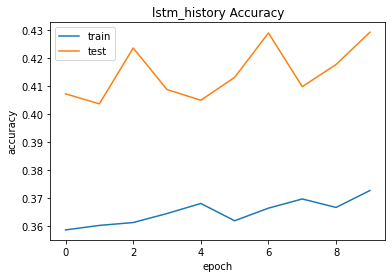

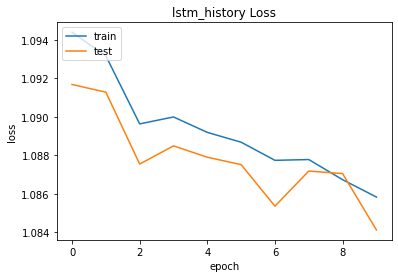

       loss  accuracy  val_loss  val_accuracy
0  1.094386  0.358654  1.091672      0.407143
1  1.093160  0.360256  1.091274      0.403571
2  1.089627  0.361282  1.087542      0.423469
3  1.089987  0.364487  1.088484      0.408673
4  1.089185  0.368077  1.087897      0.404847
5  1.088675  0.361923  1.087511      0.413010
6  1.087734  0.366410  1.085354      0.428827
7  1.087775  0.369679  1.087177      0.409694
8  1.086729  0.366667  1.087046      0.417602
9  1.085828  0.372692  1.084120      0.429082


In [ ]:
## Visualize Results      source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize lstm_history for accuracy
plt.plot(complex_lstm_history.history['accuracy'])
plt.plot(complex_lstm_history.history['val_accuracy'])
plt.title('lstm_history Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize lstm_history for loss
plt.plot(complex_lstm_history.history['loss'])
plt.plot(complex_lstm_history.history['val_loss'])
plt.title('lstm_history Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

history_pd = pd.DataFrame(complex_lstm_history.history)
print(history_pd)


## Resources
### Educational
* [DeepMind deep learning lectures](https://www.youtube.com/playlist?list=PLqYmG7hTraZCDxZ44o4p3N5Anz3lLRVZF)
### Annotation tools
* [List of open source solutions](https://www.simonwenkel.com/2019/07/19/list-of-annotation-tools-for-machine-learning-research.html)
* [opencv/cvat](https://github.com/opencv/cvat)
* [alexandre01/UltimateLabeling](https://github.com/alexandre01/UltimateLabeling)
### Existing trained models
* [onnx/models](https://github.com/onnx/models)